# Data Preparation & Predictive Feature Creation

![image.png](attachment:image.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

historical_data=pd.read_csv("Delivery Duration Prediction DoorDash.csv")

historical_data.describe().loc[["min", "max"]]

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
min,1.0,1.0,1.0,1.0,0.0,1.0,-86.0,0.0,-4.0,-5.0,-6.0,0.0,0.0
max,6.0,6987.0,7.0,411.0,27100.0,20.0,14700.0,14700.0,171.0,154.0,285.0,2715.0,2088.0


In [2]:
print(historical_data.columns)
print(historical_data.info())
print(historical_data.isna().sum())

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_

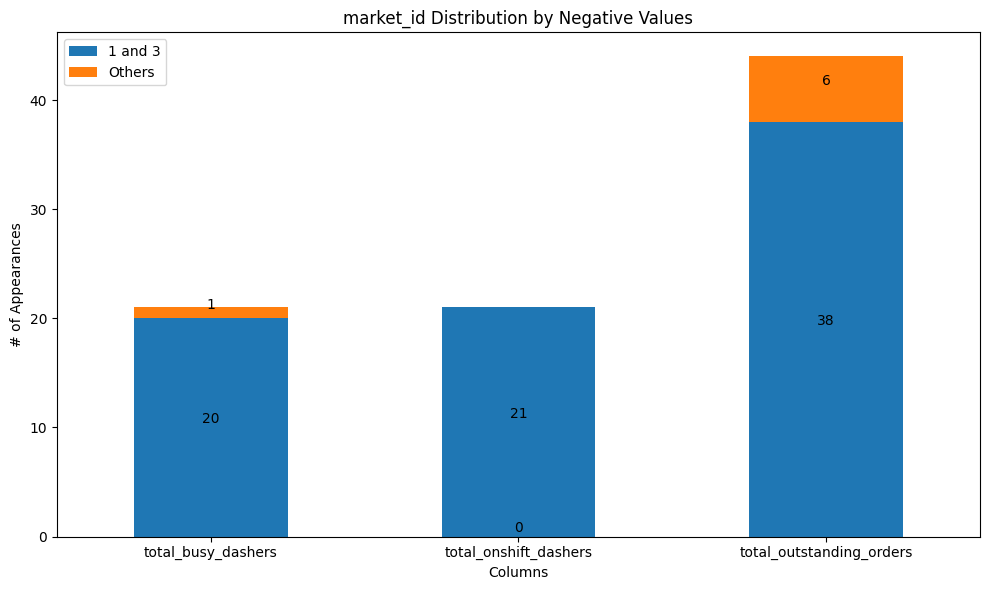

In [3]:
columns_to_check = ['total_busy_dashers', 'total_onshift_dashers', 'total_outstanding_orders']


negative_value_counts = {col: {'1 and 3': 0, 'Others': 0} for col in columns_to_check}


for col in columns_to_check:
    negative_values = historical_data[historical_data[col] < 0]

    count_1_and_3 = negative_values['market_id'].isin([1, 3]).sum()

    count_others = len(negative_values) - count_1_and_3

    negative_value_counts[col]['1 and 3'] = count_1_and_3
    negative_value_counts[col]['Others'] = count_others


df_negative_value_counts = pd.DataFrame(negative_value_counts)


ax = df_negative_value_counts.T.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('market_id Distribution by Negative Values')
plt.xlabel('Columns')
plt.ylabel('# of Appearances')
plt.xticks(rotation=0)


for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                (bar.get_x() + bar.get_width() / 2,
                 bar.get_y() + bar.get_height() / 2),
                ha='center', va='center',
                size=10, xytext=(0, 6),
                textcoords='offset points')


plt.tight_layout()
plt.show()

#### Feature Creation:
Target Variable = Actual Delivery Time (sec) - Order Creation Time (sec)

In [4]:
from datetime import datetime
historical_data['created_at']=pd.to_datetime(historical_data['created_at'])
historical_data['actual_delivery_time']=pd.to_datetime(historical_data['actual_delivery_time'])

historical_data['actual_total_delivery_duration']=historical_data['actual_delivery_time']-historical_data['created_at']
historical_data['actual_total_delivery_duration']=historical_data['actual_total_delivery_duration'].dt.total_seconds()
historical_data['actual_total_delivery_duration']

0         3779.0
1         4024.0
2         1781.0
3         3075.0
4         2390.0
           ...  
197423    3907.0
197424    3383.0
197425    3008.0
197426    3907.0
197427    2228.0
Name: actual_total_delivery_duration, Length: 197428, dtype: float64

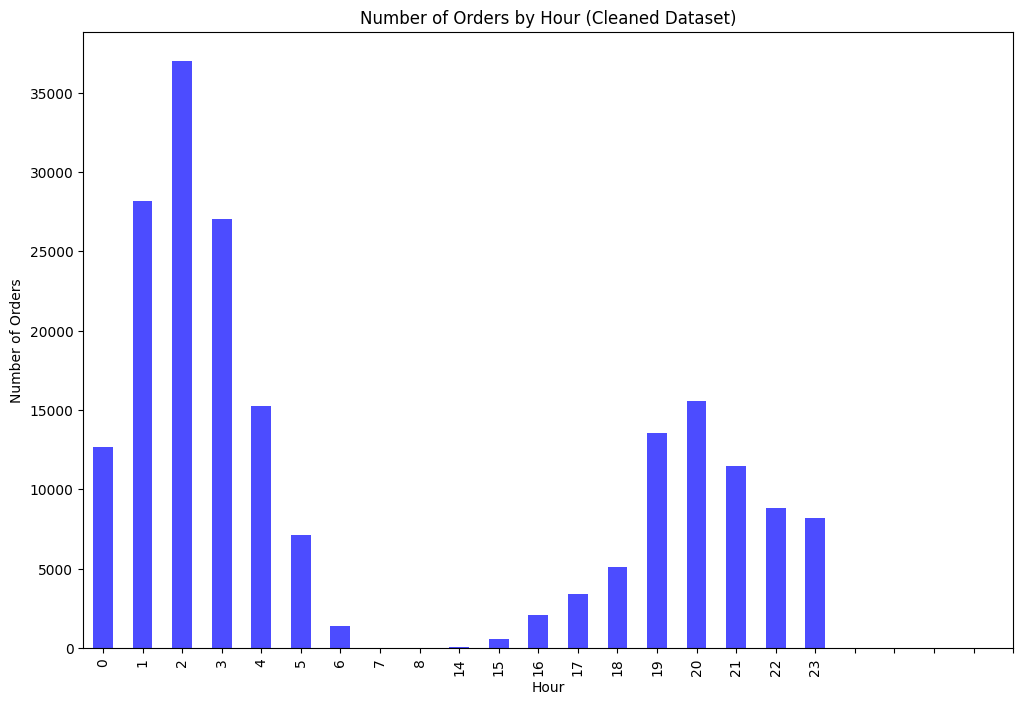

In [5]:
historical_data['hour'] = historical_data['created_at'].dt.hour


hourly_order_counts = historical_data['hour'].value_counts().sort_index()

plt.figure(figsize=(12, 8))
hourly_order_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Number of Orders by Hour (Cleaned Dataset)')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.xticks(range(0, 24))


plt.show()

In [6]:
historical_data.drop('hour', axis=1, inplace=True)

## Feature Creation:
Total Number of Available Dashers within a certain area changes time to time.

Busy Dasher Ratio = Total Busy Dasher / Total Onshift Dashers

Higher the Busy Dasher Ratio, the lesser the Dasher Capacity; hence, delivery duration will be longer.

In [7]:
historical_data['busy_dashers_ratio']=historical_data['total_busy_dashers']/historical_data['total_onshift_dashers']
historical_data['busy_dashers_ratio'].head()

0    0.424242
1    2.000000
2    0.000000
3    1.000000
4    1.000000
Name: busy_dashers_ratio, dtype: float64

In [8]:
historical_data['estimated_non_prep_duration']=historical_data['estimated_order_place_duration']+historical_data['estimated_store_to_consumer_driving_duration']
historical_data['estimated_non_prep_duration'].head()

0    1307.0
1    1136.0
2    1136.0
3     735.0
4    1096.0
Name: estimated_non_prep_duration, dtype: float64

In [9]:
historical_data[['market_id','store_id','store_primary_category','order_protocol']].nunique()

market_id                    6
store_id                  6743
store_primary_category      74
order_protocol               7
dtype: int64

Can encode market_id and order_protocol, but not store_id.

In [10]:
historical_data[['market_id','store_primary_category','order_protocol']].isna().sum()

market_id                  987
store_primary_category    4760
order_protocol             995
dtype: int64

In [11]:
order_protocol_dummies=pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies=order_protocol_dummies.add_prefix('order_protocol_')

print(order_protocol_dummies.head())

   order_protocol_1.0  order_protocol_2.0  order_protocol_3.0  \
0                   1                   0                   0   
1                   0                   1                   0   
2                   1                   0                   0   
3                   1                   0                   0   
4                   1                   0                   0   

   order_protocol_4.0  order_protocol_5.0  order_protocol_6.0  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   order_protocol_7.0  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  


In [12]:
market_id_dummies=pd.get_dummies(historical_data.market_id)
market_id_dummies=market_id_dummies.add_prefix('market_id_')

print(market_id_dummies.head())

   market_id_1.0  market_id_2.0  market_id_3.0  market_id_4.0  market_id_5.0  \
0              1              0              0              0              0   
1              0              1              0              0              0   
2              0              0              1              0              0   
3              0              0              1              0              0   
4              0              0              1              0              0   

   market_id_6.0  
0              0  
1              0  
2              0  
3              0  
4              0  


#### Reference Dictionary:
Maps each store_id to the most frequent cuisine_category they have.

In [13]:
store_id_unique=historical_data['store_id'].unique().tolist()
store_id_and_category={store_id: historical_data[historical_data['store_id']==store_id].store_primary_category.mode()
                       for store_id in store_id_unique
                       }

In [14]:
def fill(store_id):
  try: return store_id_and_category[store_id].values[0]
  except: return np.nan

historical_data['nan_free_store_primary_category']=historical_data.store_id.apply(fill)

In [15]:
store_primary_category_dummies=pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies=store_primary_category_dummies.add_prefix('store_primary_category_')

print(store_primary_category_dummies.head())

   store_primary_category_afghan  store_primary_category_african  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              0                               0   
4                              0                               0   

   store_primary_category_alcohol  store_primary_category_alcohol-plus-food  \
0                               0                                         0   
1                               0                                         0   
2                               0                                         0   
3                               0                                         0   
4                               0                                         0   

   store_primary_category_american  store_primary_category_argentine  \
0                                1          

In [16]:
train_df=historical_data.drop(columns=['store_id', 'created_at','actual_delivery_time','market_id','order_protocol','nan_free_store_primary_category','store_primary_category'])
train_df=pd.concat([train_df,order_protocol_dummies,market_id_dummies,store_primary_category_dummies],axis=1)

In [17]:
train_df=train_df.astype('float32')
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
train_df['busy_dashers_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [19]:
np.where(np.any(~np.isfinite(train_df),axis=0)==True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [20]:
train_df.replace([np.inf,-np.inf],np.nan,inplace=True)
train_df.dropna(inplace=True)

In [21]:
train_df.shape

(177070, 100)

In [22]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
count,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,...,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000,177070.000000
mean,3.205986,2702.317871,2.676100,685.919556,1163.041382,45.733845,42.605022,59.252724,308.425873,545.973572,...,0.000198,0.000113,0.005789,0.011035,0.000695,0.035579,0.001209,0.001305,0.004241,0.030982
std,2.674816,1828.827026,1.624523,521.454712,561.705750,34.287357,31.922808,52.556145,90.164322,218.421829,...,0.014058,0.010627,0.075863,0.104468,0.026347,0.185239,0.034743,0.036095,0.064987,0.173270
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1420.000000,2.000000,299.000000,799.000000,18.000000,16.000000,18.000000,251.000000,384.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2230.000000,2.000000,595.000000,1095.000000,38.000000,35.000000,42.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3423.000000,3.000000,945.000000,1398.000000,66.000000,63.000000,86.000000,446.000000,703.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
train_df['busy_dashers_ratio'].describe()

count    177070.000000
mean          0.949947
std           0.406595
min         -13.000000
25%           0.826923
50%           0.962264
75%           1.000000
max          31.000000
Name: busy_dashers_ratio, dtype: float64

## Collinearity and Removing Redundancies

Collinearity means that the variables are correlated with each other; they have the same effect on the model.

Correlation Matrix: a visual representation containing the correlation coefficients between the variables in your dataframe.

<Axes: >

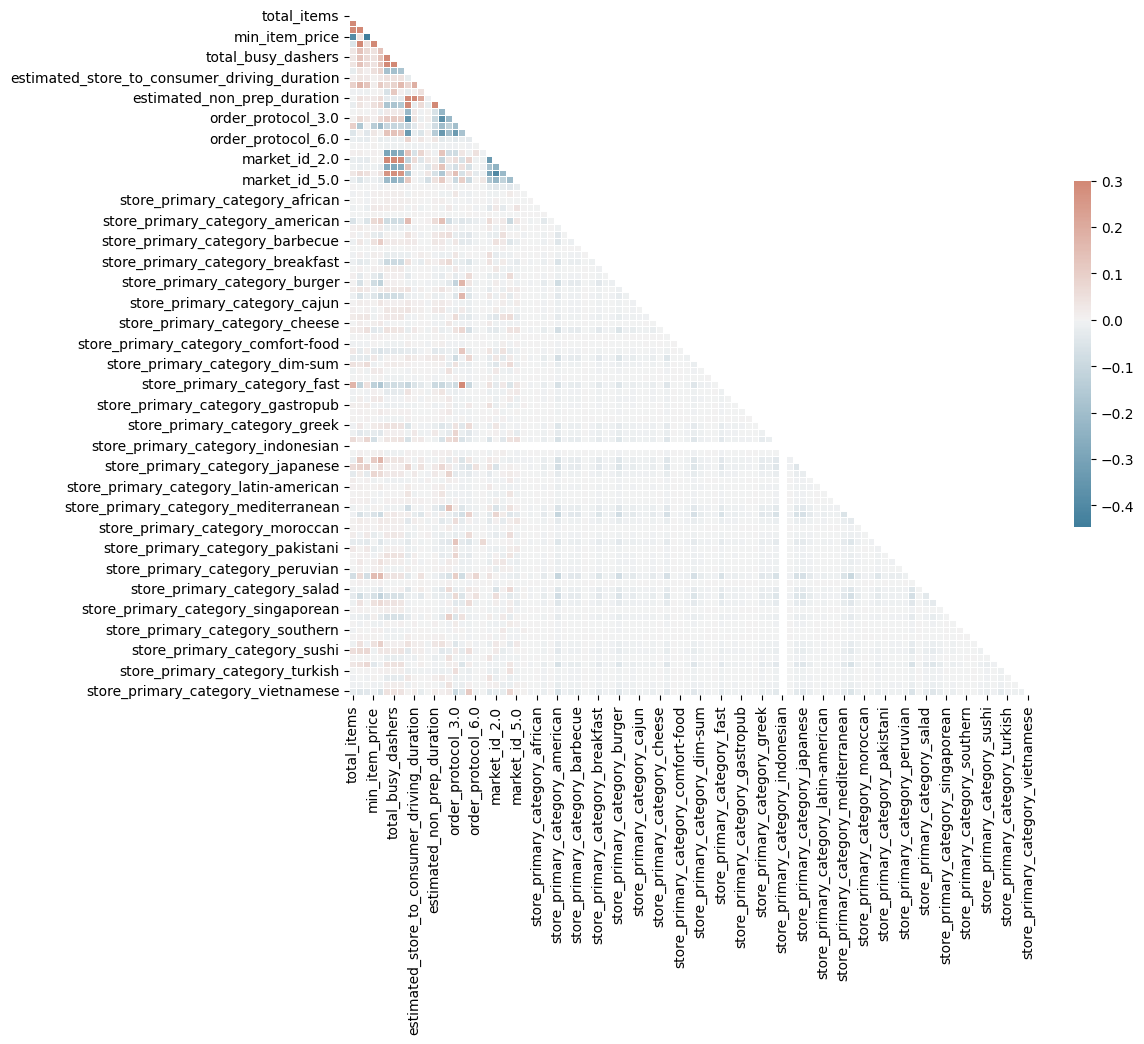

In [25]:
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap= True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
# without masked
#corr = train_df.corr()
#f, ax = plt.subplots(figsize=(11, 9))
#cmap = sns.diverging_palette(230, 20, as_cmap= True)
#sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
train_df['store_primary_category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: store_primary_category_indonesian, dtype: float64

Two functions to test the correlations:
- get redundant values
- find top correlated features

In [28]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [29]:
def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [30]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            store_primary_category_fast    0.489946
num_distinct_items          

Looks like 'total_onshift_dashers' and 'total_busy_dashers' are redundant because they are highly correlated, so we must reshape our dataset according to the results.

'estimated_store_to_consumer_driving_duration' and 'estimated_non_prep_duration' are also redundant. We created 'estimated_non_prep_duration' so we will remove this column and keep the original.

'market_id_?.?' is also correlated with each other, so we can remove those.

#### Filter Data:
Remove rows where:
- Busy_onshift_dashers < total_onshift_dashers
- negative numbers in total_onshift_dashers, total_busy_dashers, total_outstanding_orders, min_item_price (*could be a promotion/free food* or reimbursement), max_item_price

In [31]:
train_df = train_df[train_df['total_busy_dashers'] <= train_df['total_onshift_dashers']]

columns_to_check = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'min_item_price', 'max_item_price']
train_df = train_df[train_df['min_item_price'] <= train_df['max_item_price']]

for column in columns_to_check:
    train_df = train_df[train_df[column] >= 0]

print(train_df.head())

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0          4.0    3441.0                 4.0           557.0          1239.0   
2          1.0    1900.0                 1.0          1900.0          1900.0   
3          6.0    6900.0                 5.0           600.0          1800.0   
4          3.0    3900.0                 3.0          1100.0          1600.0   
5          3.0    5000.0                 3.0          1500.0          1900.0   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                   33.0                14.0                      21.0   
2                    1.0                 0.0                       0.0   
3                    1.0                 1.0                       2.0   
4                    6.0                 6.0                       9.0   
5                    2.0                 2.0                       2.0   

   estimated_order_place_duration  \
0                           446.0   


In [32]:
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)

train_df = train_df.drop(columns = ['total_onshift_dashers', 'total_busy_dashers', 'store_primary_category_indonesian', 'estimated_non_prep_duration'])

train_df = train_df.astype("float32")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

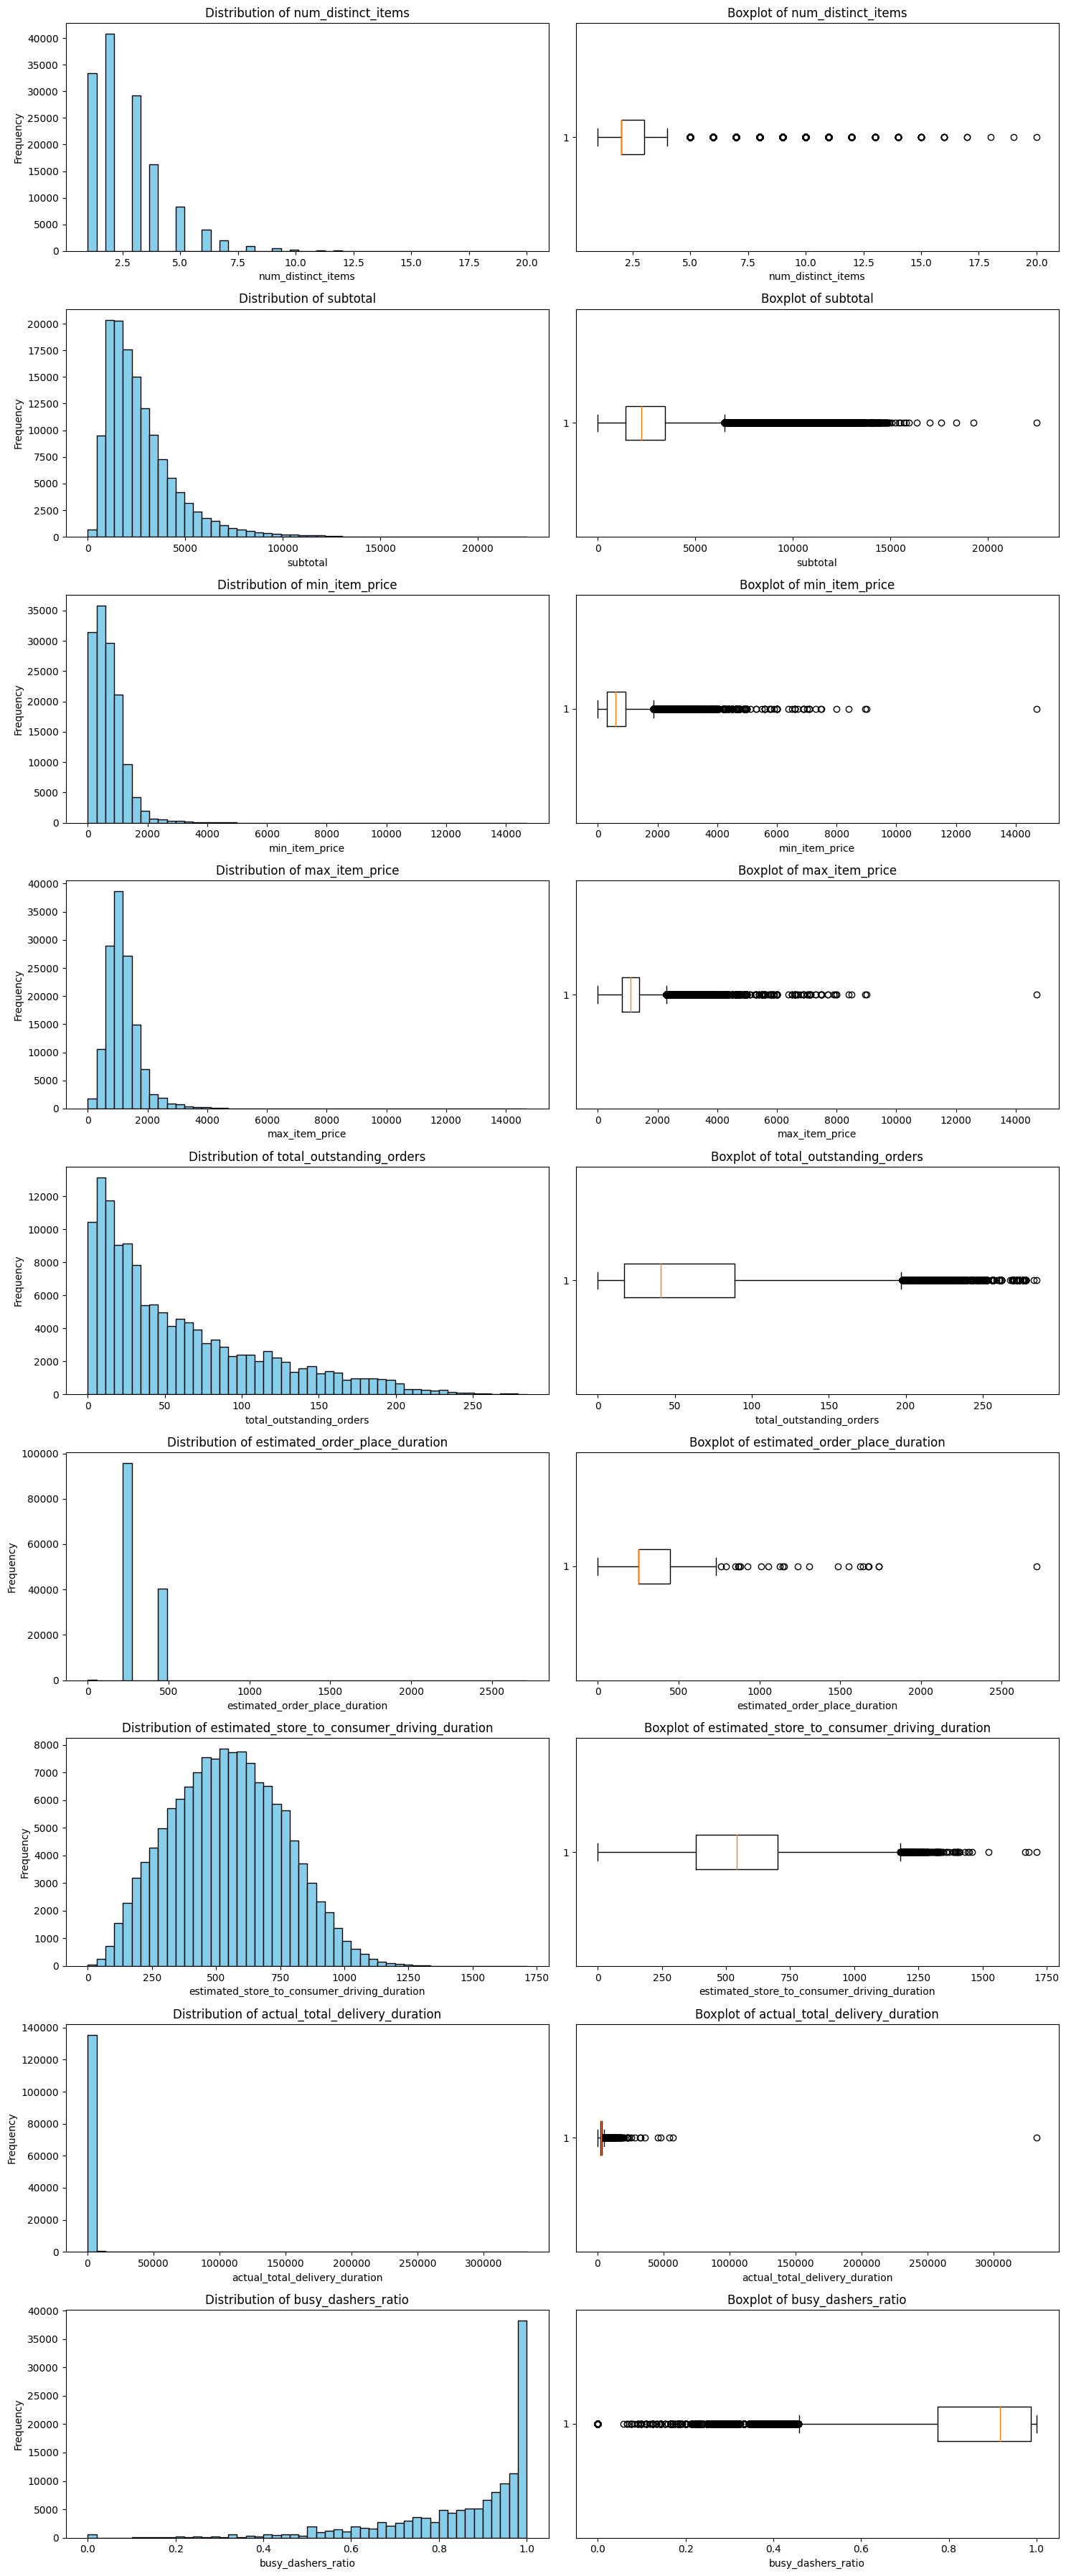

In [33]:
columns_to_visualize = ['num_distinct_items', 'subtotal', 'min_item_price', 'max_item_price',
                        'total_outstanding_orders', 'estimated_order_place_duration',
                        'estimated_store_to_consumer_driving_duration', 'actual_total_delivery_duration',
                        'busy_dashers_ratio']


fig, axes = plt.subplots(len(columns_to_visualize), 2, figsize=(15, 4 * len(columns_to_visualize)))

for i, col in enumerate(columns_to_visualize):
    axes[i, 0].hist(train_df[col], bins=50, color='skyblue', edgecolor='black')
    axes[i, 0].set_title(f'Distribution of {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')


    axes[i, 1].boxplot(train_df[col].dropna(), vert=False)
    axes[i, 1].set_title(f'Boxplot of {col}')
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()


In [34]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,5000.0,3.0,1500.0,1900.0,2.0,446.0,338.0,2300.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
train_df.shape

(136273, 176)

In [36]:
train_df

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,store_primary_category_southern,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,5000.0,3.0,1500.0,1900.0,2.0,446.0,338.0,2300.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197420,3.0,2352.0,3.0,499.0,685.0,65.0,251.0,560.0,3392.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197423,3.0,1389.0,3.0,345.0,649.0,23.0,251.0,331.0,3907.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197424,6.0,3010.0,4.0,405.0,825.0,14.0,251.0,915.0,3383.0,0.916667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197426,1.0,1175.0,1.0,535.0,535.0,12.0,446.0,384.0,3907.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
estimated_order_place_duration  order_protocol_1.0    0.894941
                                order_protocol_1.0    0.894941
total_items                     num_distinct_items    0.746675
subtotal                        num_distinct_items    0.686802
total_items                     subtotal              0.552757
min_item_price                  max_item_price        0.535628
subtotal                        max_item_price        0.508465
num_distinct_items              min_item_price        0.444880
market_id_2.0                   market_id_4.0         0.400374
total_items                     min_item_price        0.381123
estimated_order_place_duration  order_protocol_3.0    0.365637
                                order_protocol_3.0    0.365637
                                order_protocol_5.0    0.330577
                                order_protocol_5.0    0.330577
market_id_1.0                   market_id_2.0         0.309373
total_outstanding_orders     

Lots of correlations among order_protocol dummy variables, so we will not concatenate them.

In [38]:
train_df = historical_data.drop(columns = ['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time', 'nan_free_store_primary_category', 'order_protocol'])

train_df = train_df[train_df['total_busy_dashers'] <= train_df['total_onshift_dashers']]
train_df = train_df[train_df['min_item_price'] <= train_df['max_item_price']]

columns_to_check = ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'min_item_price', 'max_item_price']

for column in columns_to_check:
    train_df = train_df[train_df[column] >= 0]

train_df=pd.concat([train_df,store_primary_category_dummies],axis=1)
train_df = train_df.drop(columns = ['total_onshift_dashers', 'total_busy_dashers', 'store_primary_category_indonesian', 'estimated_non_prep_duration'])

train_df = train_df.astype("float32")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
train_df.head()

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                 0.746675
subtotal                                      num_distinct_items                 0.686802
total_items                                   subtotal                           0.552757
min_item_price                                max_item_price                     0.535628
subtotal                                      max_item_price                     0.508465
num_distinct_items                            min_item_price                     0.444880
total_items                                   min_item_price                     0.381123
total_outstanding_orders                      busy_dashers_ratio                 0.216200
                                              estimated_order_place_duration     0.180989
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration     0.179119
subtotal                                      actual_total_delivery_durati

We still have some correlated features; we must overcome this problem with feature engineering.

#### Feature Engineering: a technique that creates new variables to simplify the model and increase its accuracy by using the new variables as predictors.

In [39]:
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items'] / train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)

print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                                avg_price_per_item                0.858810
max_item_price                                avg_price_per_item                0.770937
min_item_price                                max_item_price                    0.535628
total_items                                   percent_distinct_item_of_total    0.439205
                                              min_item_price                    0.381123
                                              avg_price_per_item                0.301566
store_primary_category_pizza                  avg_price_per_item                0.230385
percent_distinct_item_of_total                avg_price_per_item                0.224617
total_outstanding_orders                      busy_dashers_ratio                0.216200
                                              estimated_order_place_duration    0.180989
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.17

got an issue with the min/max item prices, so we will create a new feature by subtracting the minimum item price from maximum item price.

In [40]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)

print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total     0.439205
                                              price_range_of_items               0.327488
                                              avg_price_per_item                 0.301566
store_primary_category_pizza                  avg_price_per_item                 0.230385
percent_distinct_item_of_total                avg_price_per_item                 0.224617
total_outstanding_orders                      busy_dashers_ratio                 0.216200
                                              estimated_order_place_duration     0.180989
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration     0.179119
store_primary_category_fast                   avg_price_per_item                 0.175067
total_items                                   store_primary_category_fast        0.164880
total_outstanding_orders                      actual_total_delivery_durati

In [41]:
train_df.shape

(136273, 82)

Feature number went down from 177 to 82, which is a good deal.

## Removing Multicollinearity

Multicollinearity is when one predictor variable in a multiple regression model can be predicted from the other variables. Makes it harder to interpret model and may cause other problems like overfitting.

VIF Factor quantifies the severity of multicollinearity.

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [43]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [44]:
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,store_primary_category_alcohol-plus-food,1.000595
1,store_primary_category_chocolate,1.000690
2,store_primary_category_belgian,1.001125
3,store_primary_category_russian,1.003318
4,store_primary_category_african,1.004552
...,...,...
76,estimated_store_to_consumer_driving_duration,7.187204
77,store_primary_category_american,7.824114
78,estimated_order_place_duration,13.495358
79,busy_dashers_ratio,25.402699


In [45]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True

selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total
I will remove busy_dashers_ratio


,feature,VIF
0,store_primary_category_alcohol-plus-food,1.000253
1,store_primary_category_chocolate,1.000463
2,store_primary_category_belgian,1.000544
3,store_primary_category_russian,1.001567
4,store_primary_category_gluten-free,1.002075
...,...,...
74,store_primary_category_pizza,3.528049
75,store_primary_category_american,3.957688
76,avg_price_per_item,5.970239
77,estimated_store_to_consumer_driving_duration,7.158519


## Feature Selection

Feature selection works to reduce the dimensions of a data set and getting rid of the features that do not have a significant effect on the model. It also helps the algorithm to work faster. One way to do this is by using PCA and Random Forest regression methods.

Random Forest with Gini Importance to measure the importance of each feature.

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

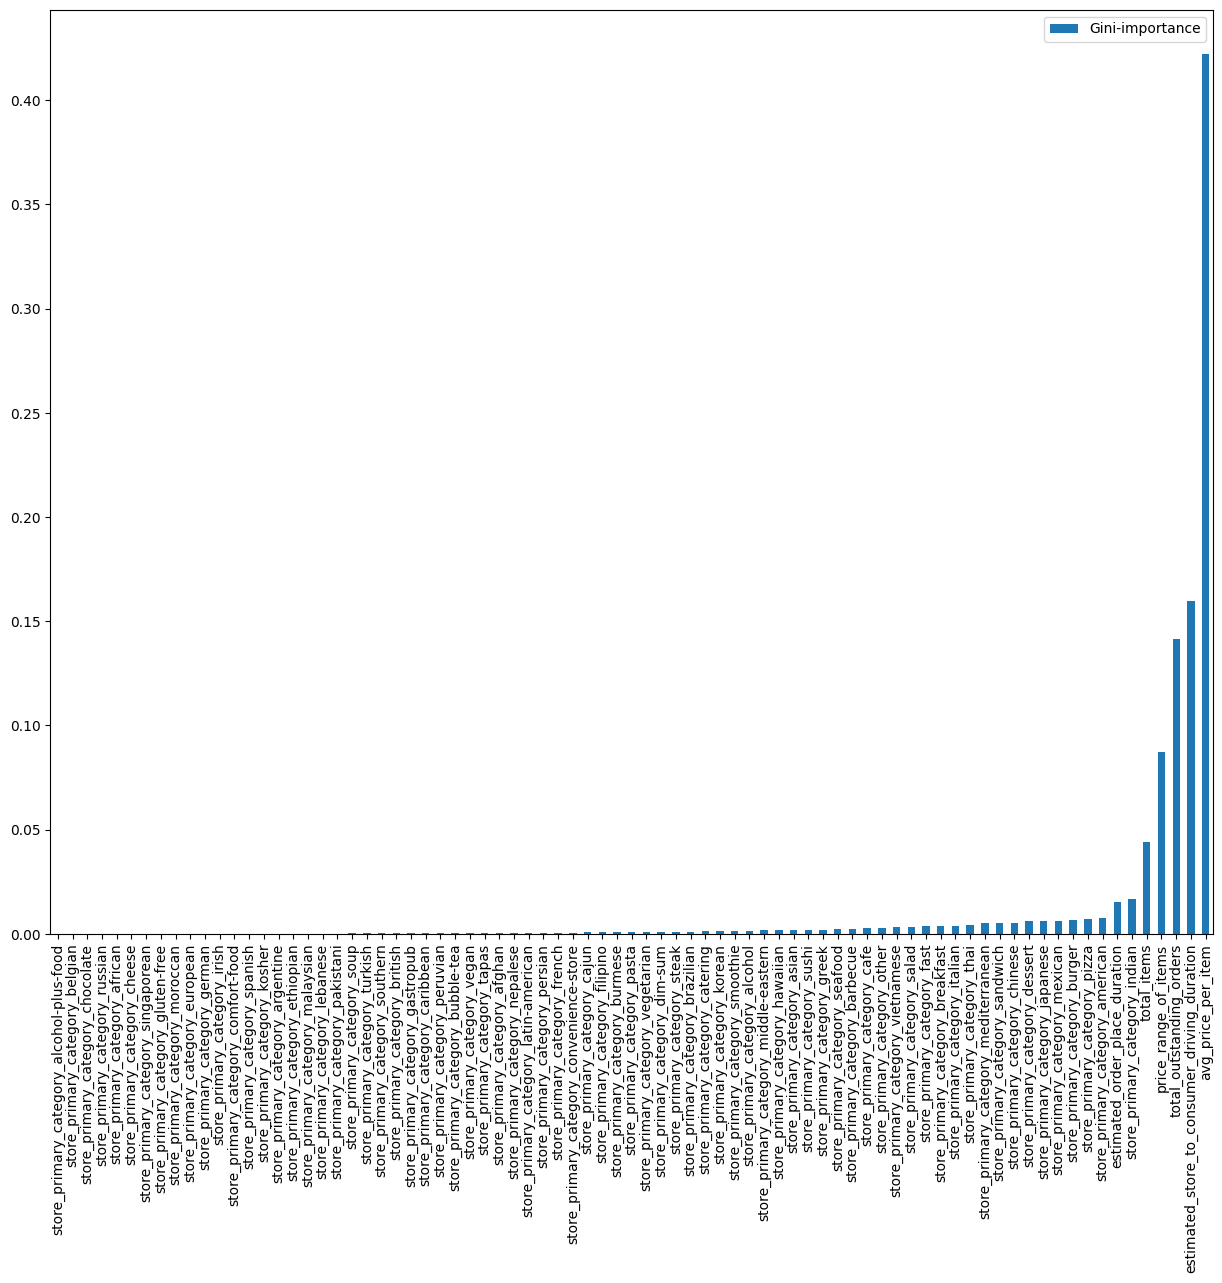

In [47]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {}
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

The graph shows that the top most important features for our model are estimated_store_to_consumer_driving_duration, avg_price_per_item, total_outstanding_orders, and there are also many other features that have a slight effect on the model.

In [48]:
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['store_primary_category_catering',
 'store_primary_category_korean',
 'store_primary_category_smoothie',
 'store_primary_category_alcohol',
 'store_primary_category_middle-eastern',
 'store_primary_category_hawaiian',
 'store_primary_category_asian',
 'store_primary_category_sushi',
 'store_primary_category_greek',
 'store_primary_category_seafood',
 'store_primary_category_barbecue',
 'store_primary_category_cafe',
 'store_primary_category_other',
 'store_primary_category_vietnamese',
 'store_primary_category_salad',
 'store_primary_category_fast',
 'store_primary_category_breakfast',
 'store_primary_category_italian',
 'store_primary_category_thai',
 'store_primary_category_mediterranean',
 'store_primary_category_sandwich',
 'store_primary_category_chinese',
 'store_primary_category_dessert',
 'store_primary_category_japanese',
 'store_primary_category_mexican',
 'store_primary_category_burger',
 'store_primary_category_pizza',
 'store_primary_category_american',
 'estimated_order_

## Reducing Dataset Dimensions

Let's use another way to diminish our features because we already have over 80 different features and there should be room for improvement.

PCA is another dimension reduction technique for regression. It also is effective at eliminating multicollinearity too. By using PCA, we can analyze how many features we have to use to explain any percentage of our data. In other words, PCA helps us to find an optimum number of features to represent our dataset.

We will fit and transform the standard scalar and then PCA. To interpret the results, we will draw a graph

<ipython-input-49-d923ce130253>:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,82,1)


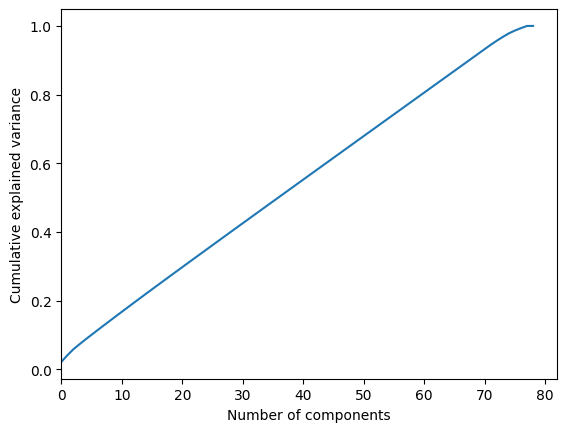

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,82,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

This plot tells us that by using 60 of the features, the data set can be explained by 80 so we already have 80 features. We can continue with the scalar.

Now, it's time to continue feature scaling, but this time, by actually scaling.

When developing a model to make further interpretation, scaling is important since it will be hard to compare the different scaled features and also some optimization algorithms like gradient descent works better after scaling. When the values of features are closed, that will be good for the model.

## Feature Scaling (Methods Used)
- Standard Scaler
- Min/Max Scaling a.k.a. Normalization

To calculate standard scaler, we first subtract the mean and divide it by the standard deviation. That might look complex, yet the logic behind it is really simple. The aim is to make the mean = 0; that's how our model performs best. Min/Max Scaler is often called normalization, which scale our features between 0 and 1, by subtracting minimum and dividing it by the difference between the minimum and maximum.

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [51]:
def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))

    return X_scaled, y_scaled, X_scaler, y_scaler

In [52]:
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42)

After applying the scaler to our feature, the scale has changed so have our predictions. To make valid interpretations, we have to inverse this process back. First, we will inverse transform to our y_predict and then we will calculate the RMSE.

In [53]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)

    return rmse_error, y_predict

We will use this function to calculate the different models and scaler RMSE. RMSE will differ according to project needs. We select RMSE and RMSE shows the distance between our predictions and real values so there we have it we've eliminated multicollinearity and performed feature selection to reduce the dimension of the dataset, and we got rid of the insignificant features of the model. Finally, we've performed feature scaling using standard and Min/Max Scaling.

#### We will apply:
- 6 different algorithms that help find the best-performing model.
- 4 different feature set sizes (Selected by GINI Importance):
    - Full
    - 40 features
    - 20 features
    - 10 features
- 3 different scalers:
    - Standard
    - Min/Max
    - No Scaler

6 algorithms x 4 feature set sizes x 3 scalers = 72 results

In [54]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

In [55]:
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model

    return trained_model, y_predict, train_error, test_error

In [56]:
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

regression_models = {
    "LinearReg": linear_model.LinearRegression(),
    "Ridge": linear_model.Ridge(),
    "DecisionTree": tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP": MLPRegressor(),
}

feature_sets = {
    "full dataset": X.columns.to_list(),
    # "selected_features_40": importances.sort_values(by='Gini-importance', ascending=False).head(40).index.tolist(),
    # "selected_features_20": importances.sort_values(by='Gini-importance', ascending=False).head(20).index.tolist(),
    # "selected_features_10": importances.sort_values(by='Gini-importance', ascending=False).head(10).index.tolist(),
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}----- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)

            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                pred_dict["regression_model"].append(model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scaler_name"].append(scaler_name)
                pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler----- included columns are full dataset

Train error = 0.998887300491333 in LinearReg
Test error = 0.7593170404434204 in LinearReg
Error = 1095.4244384765625 in LinearReg
Train error = 0.998887300491333 in Ridge
Test error = 0.7593167424201965 in Ridge
Error = 1095.424072265625 in Ridge
Train error = 0.7263030833956974 in DecisionTree
Test error = 0.7626889705393545 in DecisionTree
Error = 1100.2890010800152 in DecisionTree
Train error = 0.377332658499972 in RandomForest
Test error = 0.7676291476590438 in RandomForest
Error = 1107.4159203518464 in RandomForest
Train error = 0.6827133893966675 in XGBoost
Test error = 0.8282063007354736 in XGBoost
Error = 1194.8072509765625 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1264
[LightGBM] [Info] Number of data points in the train set: 109018, number of used

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.63726e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1047.7971040297746 in DecisionTree
Test error = 1100.2890011695554 in DecisionTree
Train error = 508.3846125526085 in RandomForest
Test error = 1107.4815076986752 in RandomForest
Train error = 984.9126586914062 in XGBoost
Test error = 1194.8072509765625 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 109018, number of used features: 67
[LightGBM] [Info] Start training from score 2825.599351
Train error = 1303.3575495474079 in LGBM
Test error = 1096.02863620691 in LGBM
Train error = 1435.70556640625 in MLP
Test error = 1082.99365234375 in MLP


## Save pred_dict to the dataframe pred_df

In [58]:
pred_df = pd.DataFrame(pred_dict)

In [59]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,LinearReg,full dataset,Standard scaler,1095.424438
1,Ridge,full dataset,Standard scaler,1095.424072
2,DecisionTree,full dataset,Standard scaler,1100.289001
3,RandomForest,full dataset,Standard scaler,1107.415920
4,XGBoost,full dataset,Standard scaler,1194.807251
5,LGBM,full dataset,Standard scaler,1094.059391
6,MLP,full dataset,Standard scaler,1088.377563
7,LinearReg,full dataset,MinMax scaler,1095.425293
8,Ridge,full dataset,MinMax scaler,1091.650146
9,DecisionTree,full dataset,MinMax scaler,1100.289000


Tells us that the using different scalars does not have much effect on the models. Therefore, we will choose a standard scaler and continue using that. Using different feature sizes also has a very minimal effect on the model so we will continue with 40 selected features.

<Axes: >

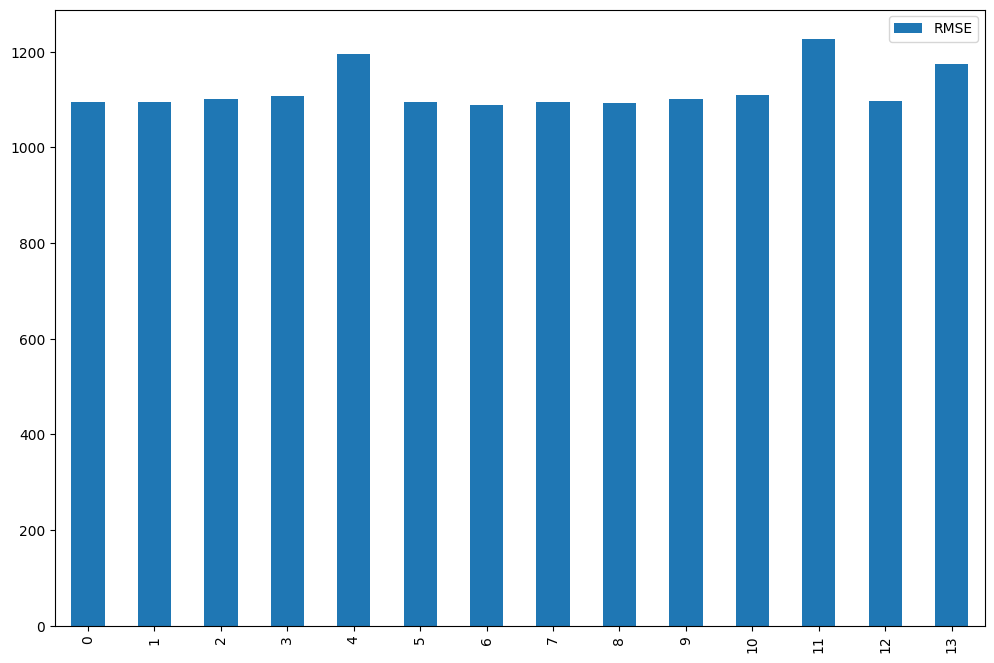

In [60]:
pred_df.plot(kind='bar', figsize=(12,8))

We see that we have high errors through all models, so there's still room for improvement.

## Let's slightly modify the problem. Predict PREP_DURATION and then calculate ACTUAL_TOTAL_DELIVERY_DURATION

In [61]:
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

Scaler: Standard



Feature size: 40 selected features

In [62]:
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

We will drop two features here because the target variable is derived from these features and collinearity is avoided by dropping them upfront.

In [63]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}----- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"])

            y = train_df["prep_time"]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)

            else:
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
                pred_dict["regression_model"].append(model_name)
                pred_dict["feature_set"].append(feature_set_name)
                pred_dict["scaler_name"].append(scaler_name)
                pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler----- included columns are selected_features_40

Train error = 1.0196260213851929 in LinearReg
Test error = 0.7753919959068298 in LinearReg
Error = 1097.640869140625 in LinearReg
Train error = 1.0196260213851929 in Ridge
Test error = 0.775391697883606 in Ridge
Error = 1097.640380859375 in Ridge
Train error = 0.735954655005836 in DecisionTree
Test error = 0.7707164565091444 in DecisionTree
Error = 1091.022180868074 in DecisionTree
Train error = 0.42291857268077865 in RandomForest
Test error = 0.8062215646337169 in RandomForest
Error = 1141.2830264390868 in RandomForest
Train error = 0.6919435262680054 in XGBoost
Test error = 0.8618054389953613 in XGBoost
Error = 1219.9671630859375 in XGBoost
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 904
[LightGBM

Scaler: Standard



Feature size: 20 selected features

In [64]:
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
}

feature_sets = {
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
}

In [65]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}----- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"])

            y = train_df["prep_time"]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler----- included columns are selected_features_20

Train error = 1.0207080841064453 in LinearReg
Test error = 0.7767986059188843 in LinearReg
Error = 1099.632080078125 in LinearReg
Train error = 1.0207080841064453 in Ridge
Test error = 0.77679842710495 in Ridge
Error = 1099.6318359375 in Ridge
Train error = 0.736024261149543 in DecisionTree
Test error = 0.7707803631031404 in DecisionTree
Error = 1091.1126467155557 in DecisionTree


KeyboardInterrupt: 

In [64]:
pred_df = pd.DataFrame(pred_dict)

In [65]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,LinearReg,selected_features_40,Standard scaler,1097.640869
1,Ridge,selected_features_40,Standard scaler,1097.640381
2,DecisionTree,selected_features_40,Standard scaler,1091.022181
3,RandomForest,selected_features_40,Standard scaler,1141.283026
4,XGBoost,selected_features_40,Standard scaler,1219.967163
5,LGBM,selected_features_40,Standard scaler,1104.374152
6,MLP,selected_features_40,Standard scaler,1088.385742
7,LinearReg,selected_features_40,MinMax scaler,1097.641479
8,Ridge,selected_features_40,MinMax scaler,1093.848511
9,DecisionTree,selected_features_40,MinMax scaler,1091.022181


Scaler: Standard



Feature size: 10 selected features

In [77]:
pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
}

feature_sets = {
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(),
}

In [78]:
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}----- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"])

            y = train_df["prep_time"]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)


            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler----- included columns are selected_features_10

Train error = 1.0216317176818848 in LinearReg
Test error = 0.7785335779190063 in LinearReg
Error = 1102.0880126953125 in LinearReg
Train error = 1.0216317176818848 in Ridge
Test error = 0.778533399105072 in Ridge
Error = 1102.0877685546875 in Ridge
Train error = 0.7363426681612566 in DecisionTree
Test error = 0.770204937606366 in DecisionTree
Error = 1090.2980773806848 in DecisionTree
Train error = 0.434114799811572 in RandomForest
Test error = 0.8229153065405344 in RandomForest
Error = 1164.914600416484 in RandomForest
Train error = 0.6961566805839539 in XGBoost
Test error = 0.8678127527236938 in XGBoost
Error = 1228.47119140625 in XGBoost
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 814
[LightGBM] [Info] Number of data points in the train set: 109018, number of

Define a dictionary to choose the best performing model and extract the PREP_DURATION predictions.

In [66]:
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(),
    "prep_duration_prediction": y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),
    "avg_price_per_item": train_df["avg_price_per_item"][test_indices].values.tolist(),
    "total_outstanding_orders": train_df["total_outstanding_orders"][test_indices].values.tolist(),
    "price_range_of_items": train_df["price_range_of_items"][test_indices].values.tolist(),
    "total_items": train_df["total_items"][test_indices].values.tolist(),
}

In [67]:
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,avg_price_per_item,total_outstanding_orders,price_range_of_items,total_items
0,2237.0,3005.186035,375.0,446.0,603.500000,13.0,949.0,6.0
1,2926.0,2530.014160,384.0,251.0,733.333313,109.0,500.0,3.0
2,2136.0,2572.439209,354.0,251.0,708.750000,120.0,945.0,4.0
3,1978.0,2615.596436,744.0,251.0,535.000000,56.0,735.0,6.0
4,2010.0,1433.763672,830.0,251.0,328.333344,15.0,60.0,3.0
...,...,...,...,...,...,...,...,...
27250,2624.0,3033.126221,634.0,446.0,1100.000000,59.0,900.0,4.0
27251,1104.0,2142.265625,369.0,251.0,1105.000000,13.0,1950.0,2.0
27252,3865.0,2266.596191,202.0,251.0,966.666687,72.0,550.0,3.0
27253,2673.0,1791.671753,315.0,446.0,424.000000,9.0,350.0,2.0


In [68]:
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"]
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,avg_price_per_item,total_outstanding_orders,price_range_of_items,total_items,sum_total_delivery_duration
0,2237.0,3005.186035,375.0,446.0,603.500000,13.0,949.0,6.0,3380.186035
1,2926.0,2530.014160,384.0,251.0,733.333313,109.0,500.0,3.0,2914.014160
2,2136.0,2572.439209,354.0,251.0,708.750000,120.0,945.0,4.0,2926.439209
3,1978.0,2615.596436,744.0,251.0,535.000000,56.0,735.0,6.0,3359.596436
4,2010.0,1433.763672,830.0,251.0,328.333344,15.0,60.0,3.0,2263.763672
...,...,...,...,...,...,...,...,...,...
27250,2624.0,3033.126221,634.0,446.0,1100.000000,59.0,900.0,4.0,3667.126221
27251,1104.0,2142.265625,369.0,251.0,1105.000000,13.0,1950.0,2.0,2511.265625
27252,3865.0,2266.596191,202.0,251.0,966.666687,72.0,550.0,3.0,2468.596191
27253,2673.0,1791.671753,315.0,446.0,424.000000,9.0,350.0,2.0,2106.671753


In [69]:
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

1289.3171801900885

## Error is still high. Time to use another approach.

We will select the top 6 features by GINI-Importance: ["prep_duration_prediction", "estimated_store_to_consumer_driving_duration",
               "estimated_order_place_duration", "avg_price_per_item",
               "price_range_of_items", "total_items"]

In [ ]:
# ! pip install interpret

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



RMSE of MLP: 1003.11
R^2 score: 0.10
Percentage of actual values within the predicted interval: 0.9686296092460099


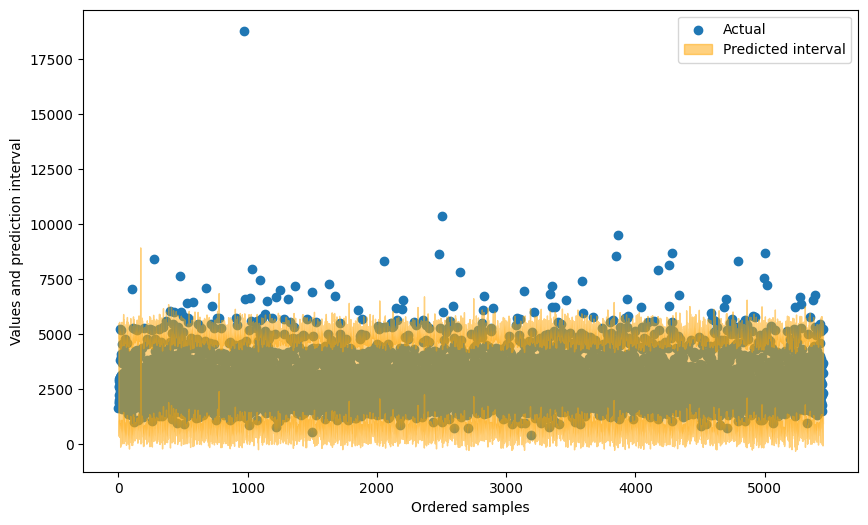

                                              Importance
estimated_store_to_consumer_driving_duration    0.103479
prep_duration_prediction                        0.037668
avg_price_per_item                              0.018828
estimated_order_place_duration                  0.018380
price_range_of_items                            0.018044
total_items                                     0.012595


In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration",
               "estimated_order_place_duration", "avg_price_per_item",
               "price_range_of_items", "total_items"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlpm = MLPRegressor(random_state=42)
mlpm.fit(X_train_scaled, y_train)

y_pred = mlpm.predict(X_test_scaled)

y_train_pred = mlpm.predict(X_train_scaled)
residuals = y_train - y_train_pred
residual_std = np.std(residuals)

interval_multiplier = 1.96
lower_bound = y_pred - interval_multiplier * residual_std
upper_bound = y_pred + interval_multiplier * residual_std

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'RMSE of MLP: {rmse:.2f}')
print(f'R^2 score: {r2:.2f}')

mlpm_actual_pred = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'lower_bound': lower_bound,
    'upper_bound': upper_bound
})

def correctPcnt(df):
    correct = ((df['lower_bound'] <= df['actual']) & (df['actual'] <= df['upper_bound'])).sum()
    return correct / len(df)

correct_percentage = correctPcnt(mlpm_actual_pred)
print("Percentage of actual values within the predicted interval:", correct_percentage)

def showIntervals(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(df.shape[0]), df['actual'], label='Actual')
    plt.fill_between(range(df.shape[0]), df['lower_bound'], df['upper_bound'], color='orange', alpha=0.5, label='Predicted interval')
    plt.xlabel('Ordered samples')
    plt.ylabel('Values and prediction interval')
    plt.legend()
    plt.show()

showIntervals(mlpm_actual_pred)

from sklearn.inspection import permutation_importance

result = permutation_importance(mlpm, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

importance = pd.DataFrame(result.importances_mean, index=X.columns, columns=["Importance"])

print(importance.sort_values(by="Importance", ascending=False))


In [80]:
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,avg_price_per_item,total_outstanding_orders,price_range_of_items,total_items,sum_total_delivery_duration
0,2237.0,1585.885986,375.0,446.0,603.500000,13.0,949.0,6.0,1960.885986
1,2926.0,1766.304810,384.0,251.0,733.333313,109.0,500.0,3.0,2150.304810
2,2136.0,1177.489258,354.0,251.0,708.750000,120.0,945.0,4.0,1531.489258
3,1978.0,2471.696533,744.0,251.0,535.000000,56.0,735.0,6.0,3215.696533
4,2010.0,677.304260,830.0,251.0,328.333344,15.0,60.0,3.0,1507.304260
...,...,...,...,...,...,...,...,...,...
27250,2624.0,1971.655029,634.0,446.0,1100.000000,59.0,900.0,4.0,2605.655029
27251,1104.0,830.312378,369.0,251.0,1105.000000,13.0,1950.0,2.0,1199.312378
27252,3865.0,1191.625122,202.0,251.0,966.666687,72.0,550.0,3.0,1393.625122
27253,2673.0,1470.235474,315.0,446.0,424.000000,9.0,350.0,2.0,1785.235474


In [81]:
# !pip install shap

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
ExactExplainer explainer: 5452it [00:33, 111.70it/s]                          


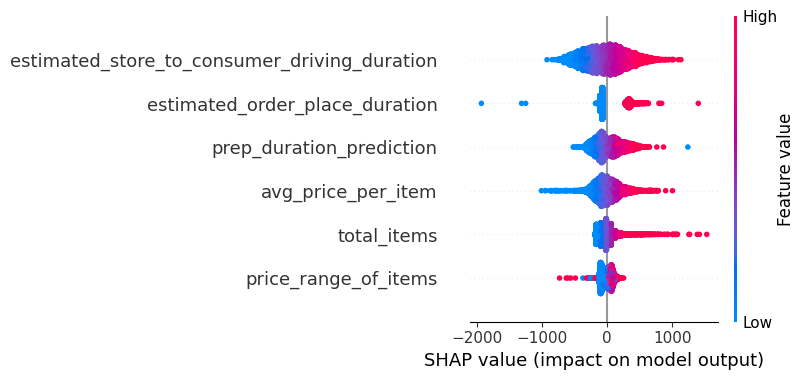

RMSE of MLP : 1013.1803467278501


In [72]:
import shap

regression_models = {
    "MLP": MLPRegressor(),
}

for model_name, model in regression_models.items():
    model.fit(X_train, y_train)

    def predict_function(X):
        return model.predict(X)

    explainer = shap.Explainer(predict_function, X_train)
    shap_values = explainer(X_test)

    shap.summary_plot(shap_values, X_test)

    y_predict = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_predict, squared=False)
    print("RMSE of", model_name, ":", rmse)

In [74]:
from interpret import show
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.metrics import mean_squared_error

ebm = ExplainableBoostingRegressor(random_state=42)

ebm.fit(X_train, y_train)

y_pred = ebm.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE of EBM: {rmse}')

from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

instance_to_explain = X_test.iloc[0]

ebm_local = ebm.explain_local(instance_to_explain.to_frame().T)
show(ebm_local)

RMSE of EBM: 997.7559177963152


Since we already used multiple different ML methods, it's time to use DL methods to compare. Because it will be DL, our model will have too many hyper parameters.

We will create a function by using both Keras and TensorFlow to create a model that predicts the actual_total_delivery_time.

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
def create_model(feature_set_size):

    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='sgd', loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [ ]:
print(f"-----scaled with {scaler_name}----- included columns are {feature_set_name}")
print("")
model_name = "ANN"
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size: ", X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Epoch means one cycle over the entire dataset. The loss quantifies the differences between actual values and the predicted ones from the entire dataset.